# Models and Feature Search
1. Try existing data on a simple MLP
2. Try VAE to get feature vectors
3. Compare performance






# 0. Load CSV and Labels to Process

In [ ]:
# @title 0.0 Mount Drive (data quality assumed to have been check prior)

import sys
import os
import time
from google.colab import drive
import pandas as pd

# Define paths
DRIVE_PATH = '/content/gdrive'

ADIGE_PATH = os.path.join(DRIVE_PATH, 'MyDrive/Team 1 - Adige BLM/') # !NOTE: Create a shortcut of the shared-folder in your drive
BIN_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database')
CSV_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_CSV')
CODING_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'coding')
LABEL_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_labels')

# Mount GDrive
try:
    # Set force_remount=True for reliability in Colab
    drive.mount(DRIVE_PATH, force_remount=True)
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    sys.exit(1)

# Wait briefly for mount
time.sleep(5)

# Check if the project directory exists
if os.path.exists(ADIGE_PATH):
    print(f"Project directory accessible at {ADIGE_PATH}\n")
else:
    print(f"Error: The project directory was not found at {ADIGE_PATH}")
    sys.exit(1)

Mounted at /content/gdrive
Project directory accessible at /content/gdrive/MyDrive/Team 1 - Adige BLM/



# 1. Import Data

In [15]:
# @title 1.0 Select which machine data to import
#machine_name = "S0872101260506"
machine_name = "LT7A2400640"

In [16]:
# @title 1.1 Load X_array, y_pw_array, y_lens_array from the pickles
# For all feature in X and for both y, plot it in plotly as a stack of plots (add range slider)

import pickle
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define path
pkl_path = os.path.join(CODING_PATH, 'restructured_data_V1', f'{machine_name}.pkl')

# 1. Load Data
print(f"Loading data from {pkl_path}...")
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

X = data['X']
y_pw = data['y_pw']
y_lens = data['y_lens']
features = data['features']

print(f"Loaded X: {X.shape}")
print(f"Loaded y_pw: {y_pw.shape}")
print(f"Loaded y_lens: {y_lens.shape}")
print(f"Loaded features: {features}")



Loading data from /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/restructured_data_V1/LT7A2400640.pkl...
Loaded X: (10567, 1024, 10)
Loaded y_pw: (10567,)
Loaded y_lens: (10567,)
Loaded features: ['$AC_VACTW (mm/min)', 'Gas set pressure (0.01 bar)', 'Gas type', 'Bar material', 'Bar thickness', 'Pressure (0.01 bar)', 'Laser set power (W)', 'Temperature lens IR (0.01 °C)', 'Temperature window IR (0.01 °C)', 'Temperature window BTS (0.01 °C)']


In [14]:
# @title 1.2 Plot X features and y labels

# 2. Prepare Data for Plotting
# X is (Samples, TimeSteps, Features).
# To visualize efficiently, we'll take the value at the LAST timestep of each segment
# This aligns with the timestamp of the label y.
plot = False
if plot:
  X_last_step = X[:, -1, :]

  # Create sample indices (0 to N-1)
  x_axis = np.arange(len(y_pw))

  # 3. Create Plotly Figure
  # Rows = Number of features + 2 labels
  num_features = len(features)
  total_rows = num_features + 2

  subplot_titles = features + ['Label: Poll PW', 'Label: Poll Lens']

  fig = make_subplots(
      rows=total_rows,
      cols=1,
      shared_xaxes=True,
      vertical_spacing=0.005,
      subplot_titles=subplot_titles
  )

  # Add Feature Traces
  for i, feature_name in enumerate(features):
      fig.add_trace(
          go.Scatter(
              x=x_axis,
              y=X_last_step[:, i],
              name=feature_name,
              mode='markers',
              marker=dict(size=3)
          ),
          row=i+1, col=1
      )

  # Add Label Traces
  # Poll PW
  fig.add_trace(
      go.Scatter(
          x=x_axis,
          y=y_pw,
          name='Poll PW',
          mode='markers',
          marker=dict(color='red', size=3)
      ),
      row=num_features + 1, col=1
  )

  # Poll Lens
  fig.add_trace(
      go.Scatter(
          x=x_axis,
          y=y_lens,
          name='Poll Lens',
          mode='markers',
          marker=dict(color='orange', size=3)
      ),
      row=num_features + 2, col=1
  )

  # 4. Layout Settings
  fig.update_layout(
      height=200 * total_rows,
      title=f"Feature Values (at segment end) vs Labels - {machine_name}",
      showlegend=False
  )

  # Add Range Slider to the bottom plot
  fig.update_xaxes(rangeslider=dict(visible=True), row=total_rows, col=1)

  fig.show()

In [17]:
# @title 1.3 Preprocess Data

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Normalize X
# X shape is (Samples, TimeSteps, Features) -> (8793, 1024, 10),
# note how in a day there are multiple segments (for all days, it's 8793 segments), which then continues to the next (day info is not considered anymore)
# and each segment contains is 51sec equivalent to 1024 samples. These samples are of 10 values from 10 sensors.
# Note also that each segment has 50% intersection with the next (windowing)
# We want to scale each Feature independently.
N, T, F = X.shape

# Flatten to (Total_TimeSteps, Features) to learn scaling parameters per feature
X_flat_features = X.reshape(-1, F)

scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat_features)

# Reshape back to (N, T, F) for Encoder input
X_scaled = X_scaled_flat.reshape(N, T, F)

print(f"Processed X shape for Encoder: {X_scaled.shape}")

# 2. Bin y_pw into 10 categories (0-100 range)
# Bins: 0-10, 10-20, ..., 90-100
# We clip to 0-99.99 before division to ensure 100 doesn't create an 11th class if present,
# or we can simply clip the resulting indices.
y_classes = np.floor(y_pw / 10).astype(int)
y_classes = np.clip(y_classes, 0, 9) # Ensure classes are 0-9

# One-hot encode
y_onehot = to_categorical(y_classes, num_classes=10)

print(f"Processed y shape: {y_onehot.shape}")
print(f"Sample classes: {y_classes[:10]}")

# 3. Split Data (90% Train, 10% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.10, random_state=42, shuffle=True
)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Processed X shape for Encoder: (10567, 1024, 10)
Processed y shape: (10567, 10)
Sample classes: [0 0 0 0 0 0 0 0 0 0]
Train shape: (9510, 1024, 10), (9510, 10)
Test shape: (1057, 1024, 10), (1057, 10)


# 2. Simple Transformer Encoder

Loading model from checkpoint: /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/best_transformer_model_mlp_head.keras to resume training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 64)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 1024, 64)       │        25,216 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,088 (988.63 KB)

 Trainable params: 84,362 (329.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,726 (659.09 KB)

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7879 - loss: 0.4684
Epoch 1: val_accuracy improved from -inf to 0.78662, saving model to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/best_transformer_model_mlp_head.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 783s 7s/step - accuracy: 0.7879 - loss: 0.4684 - val_accuracy: 0.7866 - val_loss: 0.5014
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7919 - loss: 0.4686
Epoch 2: val_accuracy improved from 0.78662 to 0.80051, saving model to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/best_transformer_model_mlp_head.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 798s 7s/step - accuracy: 0.7919 - loss: 0.4686 - val_accuracy: 0.8005 - val_loss: 0.4593
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7985 - loss: 0.4586
Epoch 3: val_accuracy did not improve from 0.80051
112/112 ━━━━━━━━━━━━━━━━━━━━ 798s 7s/step - accuracy: 0.7985 - loss: 0.4587 - val_accuracy: 0.7866 - val_loss: 0.5089
Epoch 4/3

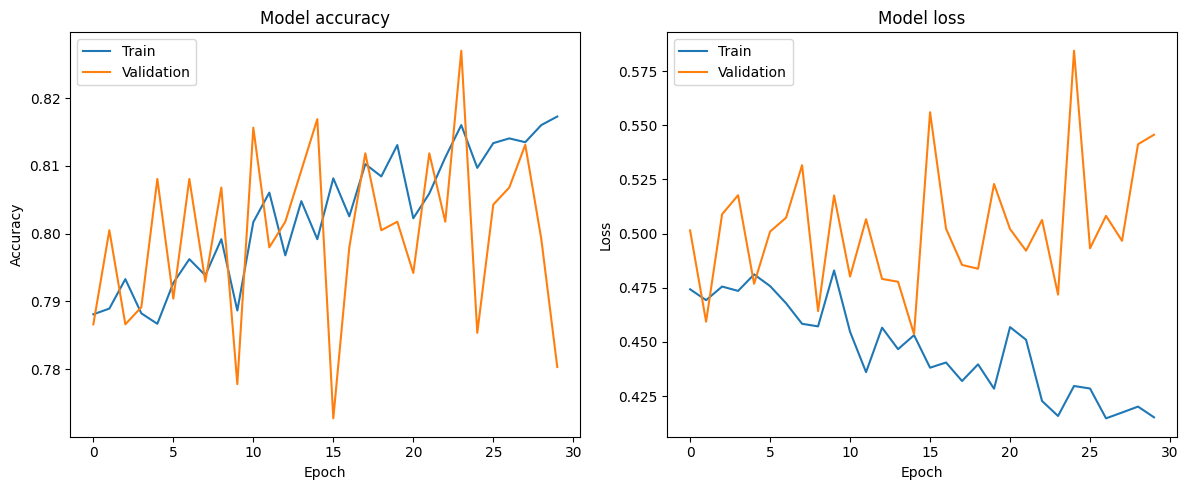

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint # Import ModelCheckpoint
import os
import matplotlib.pyplot as plt

# --- Control Flag for Training ---
restart_training_from_scratch = False # Set to True to always start from scratch, False to resume if checkpoint exists

# --- 1. Positional Encoding Utility ---
def get_sin_cos_positional_encoding(length, d_model):
    """
    Generates sinusoidal positional encoding.
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    P = np.zeros((length, d_model))
    positions = np.arange(length)[:, np.newaxis]

    # Compute the division term
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    # Apply sin to even indices
    P[:, 0::2] = np.sin(positions * div_term)

    # Apply cos to odd indices
    P[:, 1::2] = np.cos(positions * div_term)

    return tf.cast(P, dtype=tf.float32)

# --- 2. Transformer Encoder Block with serialization support ---
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

        # Store config for serialization
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def build(self, input_shape):
        # Ensure the attention layer is built with the correct input dimension
        # The input shape is (batch_size, sequence_length, embed_dim)
        # The key_dim is already set in __init__ for MultiHeadAttention based on embed_dim // num_heads
        # No need to explicitly call build on sub-layers if they handle it internally or are Sequential
        super().build(input_shape)

    def call(self, inputs, training=False):
        # Self-Attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm

        # Feed Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

# --- 3. Build Model ---
def build_transformer_model(input_shape, num_classes, embed_dim=64, num_heads=4, ff_dim=64):
    inputs = layers.Input(shape=input_shape)

    # Linear Embedding: Project input features (10) -> embed_dim (32)
    x = layers.Dense(embed_dim)(inputs)

    # Add Positional Encoding
    # Note: We add it to the projected embeddings
    pe = get_sin_cos_positional_encoding(input_shape[0], embed_dim)
    x = x + pe

    # Transformer Encoder Layer
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Classification Head
    # Global Average Pooling to flatten over time dimension
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)


    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- 4. Instantiate and Train ---
input_shape = (1024, 10) # (TimeSteps, Features)
num_classes = 10

# Define checkpoint path
checkpoint_filepath = os.path.join(CODING_PATH, 'models', 'best_transformer_model_mlp_head.keras')

# Check if a checkpoint exists and load the model, or build a new one
if not restart_training_from_scratch and os.path.exists(checkpoint_filepath):
    print(f"Loading model from checkpoint: {checkpoint_filepath} to resume training.")
    # Pass custom objects to load_model
    custom_objects = {
        "TransformerBlock": TransformerBlock,
        # 'get_sin_cos_positional_encoding' is not a layer, but if the model's config implicitly refers to it,
        # having it defined in scope helps. For explicit custom objects, it's usually layers/models.
        "get_sin_cos_positional_encoding": get_sin_cos_positional_encoding
    }

    model = keras.models.load_model(checkpoint_filepath, custom_objects=custom_objects)
else:
    if restart_training_from_scratch:
        print("Flag 'restart_training_from_scratch' is True. Building a new model from scratch.")
    else:
        print("No checkpoint found. Building a new model.")
    model = build_transformer_model(input_shape, num_classes)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

# Define checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,      # Save only the best model
    monitor='val_accuracy',   # Monitor validation accuracy
    mode='max',               # Save when val_accuracy is maximized
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_callback] # Add the callback here
)

# Plot training history (moved from previous cell)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
import os

# Define path for the last model
last_model_filepath = os.path.join(CODING_PATH, 'models', f'{machine_name}_last_transformer_model_mlp_head.keras')

# Save the model
model.save(last_model_filepath)
print(f"Last model saved to: {last_model_filepath}")

Last model saved to: /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/S0872101260506_last_transformer_model_mlp_head.keras


In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --- Re-define get_sin_cos_positional_encoding (needed if build_transformer_model was called in custom_objects, though not strictly for this error)
# Even if not directly passed as custom_object, having it in scope can help if the model's config refers to it implicitly.
def get_sin_cos_positional_encoding(length, d_model):
    P = np.zeros((length, d_model))
    positions = np.arange(length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    P[:, 0::2] = np.sin(positions * div_term)
    P[:, 1::2] = np.cos(positions * div_term)
    return tf.cast(P, dtype=tf.float32)


# --- Re-define TransformerBlock with serialization support ---
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

        # Store config for serialization
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def build(self, input_shape):
        # Ensure the attention layer is built with the correct input dimension
        # The input shape is (batch_size, sequence_length, embed_dim)
        # The key_dim is already set in __init__ for MultiHeadAttention based on embed_dim // num_heads
        # No need to explicitly call build on sub-layers if they handle it internally or are Sequential
        super().build(input_shape)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


# Load the best model saved by the checkpoint (this will ensure we load the best one even if training was resumed)
print(f"Loading best model from {checkpoint_filepath}")

# Pass custom objects to load_model
custom_objects = {
    "TransformerBlock": TransformerBlock,
    # 'get_sin_cos_positional_encoding' is not a layer, but if the model's config implicitly refers to it,
    # having it defined in scope helps. For explicit custom objects, it's usually layers/models.
    "get_sin_cos_positional_encoding": get_sin_cos_positional_encoding
}

best_model = keras.models.load_model(checkpoint_filepath, custom_objects=custom_objects)

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Best Model): {loss:.4f}")
print(f"Test Accuracy (Best Model): {accuracy:.4f}")


Loading best model from /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/best_transformer_model_mlp_head.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8324 - loss: 0.4309
Test Loss (Best Model): 0.4487
Test Accuracy (Best Model): 0.8216


In [18]:
import numpy as np
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score

# Get predictions from the best model
y_pred_probs = best_model.predict(X_test)

# Convert one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Calculate Metrics ---

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# F1-score (using macro average for multi-class classification)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Precision (using macro average for multi-class classification)
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)

# Recall (using macro average for multi-class classification)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)

# Mean Absolute Error (MAE) on class labels
mae = mean_absolute_error(y_true_classes, y_pred_classes)

# Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) on class labels
mse = mean_squared_error(y_true_classes, y_pred_classes)
rmse = np.sqrt(mse)

print(f"--- Best Model Metrics on Test Set ({machine_name})---")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (Macro Average): {f1:.4f}")
print(f"Precision (Macro Average): {precision:.4f}")
print(f"Recall (Macro Average): {recall:.4f}")
print(f"Mean Absolute Error (MAE) on class labels: {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) on class labels: {rmse:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step
--- Best Model Metrics on Test Set (LT7A2400640)---
Accuracy: 0.3860
F1-score (Macro Average): 0.1803
Precision (Macro Average): 0.1811
Recall (Macro Average): 0.1837
Mean Absolute Error (MAE) on class labels: 0.8704
Root Mean Squared Error (RMSE) on class labels: 1.2242


#Scratch Work

In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint # Import ModelCheckpoint

# ---------------------------
# Positional Encoding Layer
# ---------------------------
class PositionalEncoding(layers.Layer):
    def __init__(self, max_seq_len=5000, d_model=512, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.max_seq_len = int(max_seq_len)
        self.d_model = int(d_model)
        self.dropout = layers.Dropout(dropout)

        # Build the constant sinusoidal positional encoding matrix once
        pos = np.arange(self.max_seq_len)[:, np.newaxis]  # (max_seq_len, 1)
        i = np.arange(self.d_model)[np.newaxis, :]       # (1, d_model)
        angle_rates = 1 / (10000 ** ((2 * (i // 2)) / np.float32(self.d_model)))
        pe = pos * angle_rates  # (max_seq_len, d_model)
        pe[:, 0::2] = np.sin(pe[:, 0::2])
        pe[:, 1::2] = np.cos(pe[:, 1::2])
        pe = pe.astype(np.float32)

        # Store as a constant (1, max_seq_len, d_model) for easy broadcasting
        self.pe = tf.constant(pe[np.newaxis, :, :])  # shape (1, max_seq_len, d_model)

    def call(self, x, training=False):
        # x shape: (batch, seq_len, d_model)
        seq_len = tf.shape(x)[1]
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x, training=training)

# ---------------------------
# Single Encoder Layer (Add&Norm style)
# ---------------------------
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, n_head, ffn_hidden, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.n_head = n_head
        self.ffn_hidden = ffn_hidden

        # Multi-head attention: key_dim = d_model // n_head (size per head)
        self.mha = layers.MultiHeadAttention(num_heads=n_head, key_dim=d_model // n_head, dropout=dropout)
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        # Position-wise feed forward
        self.ffn = keras.Sequential(
            [
                layers.Dense(ffn_hidden, activation="relu"),
                layers.Dense(d_model),
            ]
        )
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=False):
        # Self-attention
        attn_output = self.mha(query=x, value=x, key=x, training=training)  # (batch, seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        x = self.norm1(x + attn_output)  # Add & Norm

        # FFN
        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output, training=training)
        x = self.norm2(x + ffn_output)  # Add & Norm
        return x

# ---------------------------
# Encoder: stack of Encoder Layers
# ---------------------------
class TransformerEncoder(layers.Layer):
    def __init__(self, n_layers, d_model, n_head, ffn_hidden, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.layers_list = [TransformerEncoderLayer(d_model=d_model, n_head=n_head, ffn_hidden=ffn_hidden, dropout=dropout)
                            for _ in range(n_layers)]

    def call(self, x, training=False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x

# ---------------------------
# Classification Head (similar deep MLP)
# ---------------------------
def ClassificationHead(seq_len, d_model, n_classes, dropout=0.1):
    return keras.Sequential(
        [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Flatten(),  # flatten entire (seq_len * d_model)
            layers.Dense(256), layers.ReLU(),
            layers.Dropout(dropout),
            layers.Dense(128), layers.ReLU(),
            layers.Dropout(dropout),
            layers.Dense(64), layers.ReLU(),
            layers.Dropout(dropout),
            layers.Dense(n_classes)  # outputs logits; apply softmax in compile/training
        ],
        name="classification_head"
    )

# ---------------------------
# Full Model Builder
# ---------------------------
def build_keras_transformer(
    input_shape=(1024, 10),
    n_classes=10,
    d_model=100,
    n_head=4,
    n_layers=2,
    ffn_hidden=128,
    pe_max_len=5000,
    dropout=0.1
):
    """
    input_shape: (seq_len, n_features)  e.g. (1024, 10)
    Returns a Keras Model that closely matches the PyTorch architecture you posted.
    """
    seq_len, n_features = input_shape

    inputs = layers.Input(shape=input_shape, name="sensor_input")  # (batch, seq_len, n_features)

    # 1) Input projection: project each time-step's feature vector -> d_model
    x = layers.Dense(d_model, name="input_projection")(inputs)   # (batch, seq_len, d_model)

    # 2) Positional Encoding + dropout
    x = PositionalEncoding(max_seq_len=pe_max_len, d_model=d_model, dropout=dropout)(x)

    # 3) Encoder stack (n_layers)
    x = TransformerEncoder(n_layers=n_layers, d_model=d_model, n_head=n_head, ffn_hidden=ffn_hidden, dropout=dropout)(x)

    # 4) Classification head: LayerNorm + Flatten + deep MLP -> logits
    head = ClassificationHead(seq_len=seq_len, d_model=d_model, n_classes=n_classes, dropout=dropout)
    outputs = head(x)  # logits shape (batch, n_classes)

    model = keras.Model(inputs=inputs, outputs=outputs, name="KerasTransformer")
    return model

# ---------------------------
# Example usage
# ---------------------------
# Example defaults to mirror the PyTorch example
seq_len = 1024
n_features = 10
n_classes = 10

model = build_keras_transformer(
    input_shape=(seq_len, n_features),
    n_classes=n_classes,
    d_model=100,
    n_head=8,
    n_layers=1,
    ffn_hidden=128,
    pe_max_len=1024,
    dropout=0.1
)

# Model summary
model.summary()

# Compile for training (use from_logits=True since our model returns logits)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define checkpoint path and callback
checkpoint_filepath = 'best_model_checkpoint.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,      # Save only the best model
    monitor='val_accuracy',   # Monitor validation accuracy
    mode='max',               # Save when val_accuracy is maximized
    verbose=1
)

# Train the model with the checkpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint_callback] # Add the callback here
)

import matplotlib.pyplot as plt

# Load the best model saved by the checkpoint
print(f"Loading best model from {checkpoint_filepath}")
best_model = keras.models.load_model(checkpoint_filepath)

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Best Model): {loss:.4f}")
print(f"Test Accuracy (Best Model): {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Model: "KerasTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sensor_input (InputLayer)       │ (None, 1024, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_projection (Dense)        │ (None, 1024, 100)      │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_3           │ (None, 1024, 100)      │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 1024, 100)      │        65,016 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 10)             │    26,256,658 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,322,774 (100.41 MB)

 Trainable params: 26,322,774 (100.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1471 - loss: 6.8287
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model_checkpoint.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 772s 7s/step - accuracy: 0.1471 - loss: 6.8339 - val_accuracy: 0.0000e+00 - val_loss: 6.1161
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0173 - loss: 7.3835
Epoch 2: val_accuracy did not improve from 0.00000
112/112 ━━━━━━━━━━━━━━━━━━━━ 744s 7s/step - accuracy: 0.0172 - loss: 7.3881 - val_accuracy: 0.0000e+00 - val_loss: 6.1867
Epoch 3/20
 68/112 ━━━━━━━━━━━━━━━━━━━━ 4:37 6s/step - accuracy: 0.0608 - loss: 7.0034

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        # key_dim: size of each attention head for query and key
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Self-Attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm

        # Feed Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm